In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket,cost_efficiency
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,0,1879,0,1,4,0,1,0,0.040620
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,0,1879,0,1,1,0,1,0,0.046524
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1,1879,0,1,1,0,0,3,0.001787
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1,1879,0,1,0,0,1,2,0.244867
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,0,1879,0,1,4,0,1,0,0.026970


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket,cost_efficiency
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,1879,0,1,4,0,1,0,0.040620
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,1879,0,1,1,0,1,0,0.046524
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1879,0,1,1,0,0,3,0.001787
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1879,0,1,0,0,1,2,0.244867
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,1879,0,1,4,0,1,0,0.026970


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)

Mutual Information Scores:
              Feature  MI Score
16    dependents_flag  0.035680
1              gender  0.033095
14          age_group  0.010046
0     telecom_partner  0.009781
6      num_dependents  0.007103
4                city  0.006840
15  is_senior_citizen  0.006635
13     loyal_customer  0.006576
12    recent_customer  0.005854
17     salary_bracket  0.003448
9            sms_sent  0.001925
3               state  0.001376
2                 age  0.000556
11        tenure_days  0.000384
10          data_used  0.000137
8          calls_made  0.000063
7    estimated_salary  0.000000
5             pincode  0.000000
18    cost_efficiency  0.000000


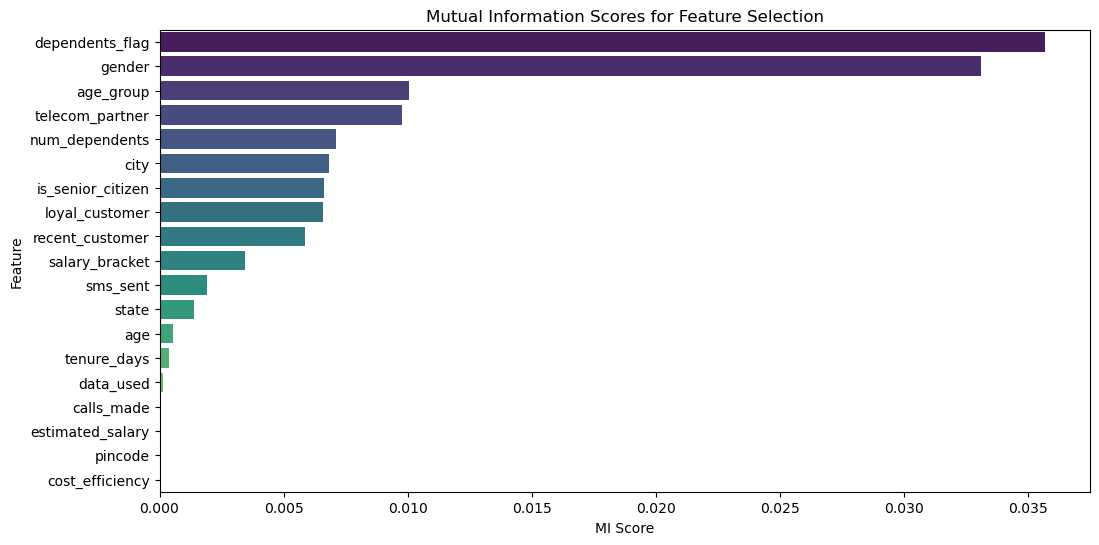

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select Features with MI Score > 0
selected_features = mi_data[mi_data['MI Score'] > 0]['Feature'].tolist()
X = X[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['dependents_flag', 'gender', 'age_group', 'telecom_partner', 'num_dependents', 'city', 'is_senior_citizen', 'loyal_customer', 'recent_customer', 'salary_bracket', 'sms_sent', 'state', 'age', 'tenure_days', 'data_used', 'calls_made']


In [7]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 157555, 0: 77561})


In [8]:
# Checking feature distributions after SMOTEENN
print("Feature distibutions after resampling:")
print(pd.DataFrame(X_train_resampled).describe())

Feature distibutions after resampling:
       dependents_flag         gender      age_group  telecom_partner  \
count    235116.000000  235116.000000  235116.000000    235116.000000   
mean          0.714775       0.470763       1.614420         1.298176   
std           0.451523       0.499146       1.500544         1.030678   
min           0.000000       0.000000       0.000000         0.000000   
25%           0.000000       0.000000       0.000000         0.000000   
50%           1.000000       0.000000       1.000000         1.000000   
75%           1.000000       1.000000       3.000000         2.000000   
max           1.000000       1.000000       4.000000         3.000000   

       num_dependents           city  is_senior_citizen  loyal_customer  \
count   235116.000000  235116.000000      235116.000000    235116.00000   
mean         1.787620       2.289393           0.190957         0.24863   
std          1.299657       1.560461           0.393056         0.43222   
min

In [9]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [10]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (188092, 16)
X_test shape: (47024, 16)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
#List to store models
models = []

In [13]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)       
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_probabilities)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print("Best Threshold for Classification:", best_threshold)
    y_pred_model = (y_probabilities > best_threshold).astype(int)
    
    #Try different threshold values 
    #threshold = 0.4
    #y_pred_model = (y_probabilities > threshold).astype(int)
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
   
    plt.figure(figsize=(12,6))
   
    
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()
    
   

Best Threshold for Classification: 0.3787866885378529
Precision:  0.6907639577884008
Recall:  0.9721375983752222
F1 Score:  0.8076456630635381
ROC AUC Score:  0.7089758249712186


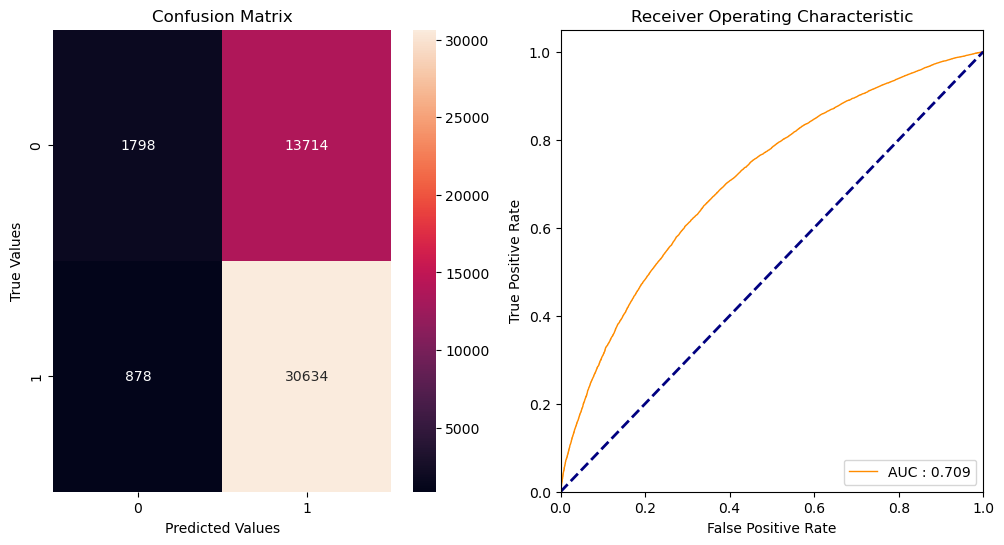

In [14]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Best Threshold for Classification: 1.0
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
ROC AUC Score:  0.7082644891715735


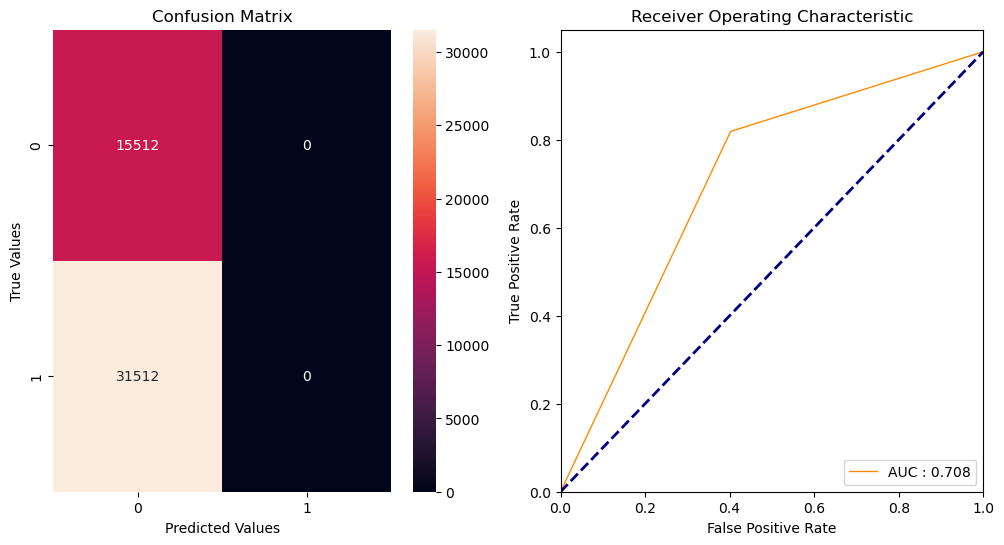

In [15]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Best Threshold for Classification: 0.2713382314548291
Precision:  0.7136351589041756
Recall:  0.93989591266819
F1 Score:  0.8112853523248649
ROC AUC Score:  0.7448845874639831


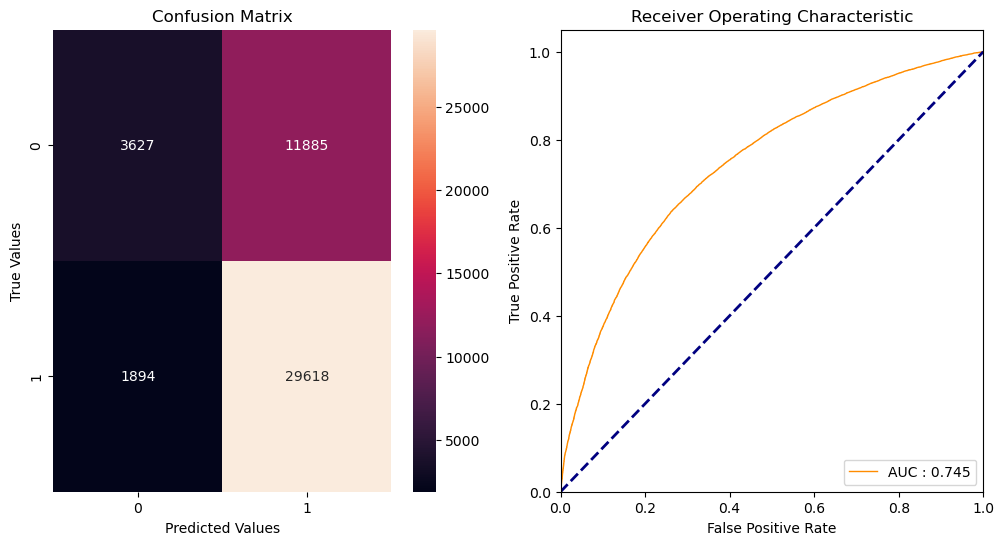

In [16]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Best Threshold for Classification: 0.54
Precision:  0.8723304231027535
Recall:  0.8243843615130744
F1 Score:  0.847679958232722
ROC AUC Score:  0.8756531858865361


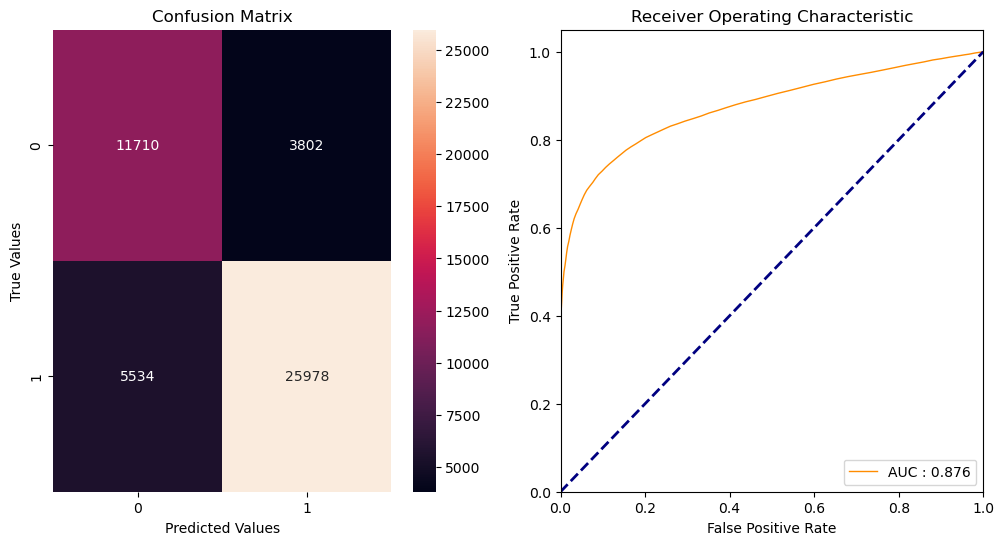

In [17]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Best Threshold for Classification: 0.5326105906203406
Precision:  0.809260086348072
Recall:  0.8624968266057375
F1 Score:  0.8350308001904849
ROC AUC Score:  0.852582768145105


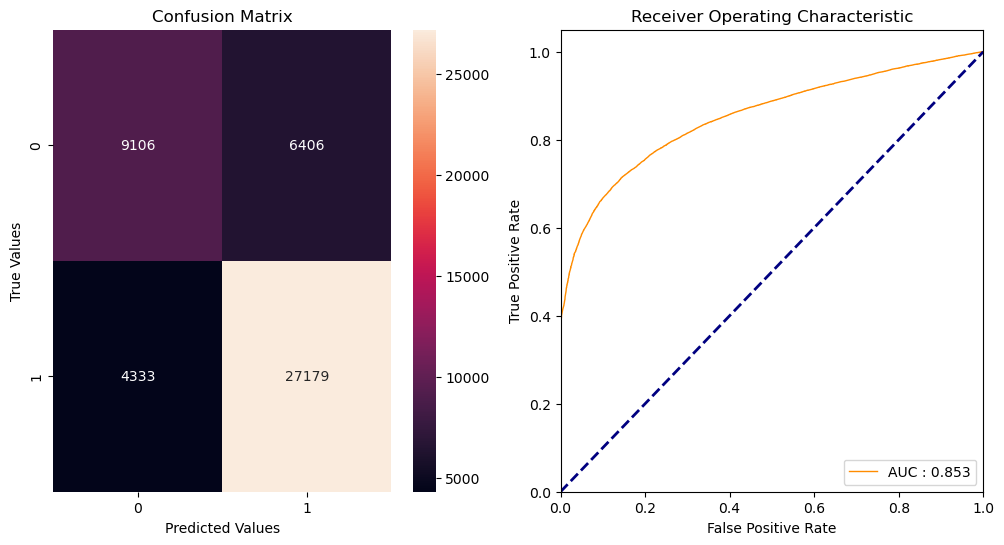

In [18]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Best Threshold for Classification: 0.52436686
Precision:  0.9227567408280536
Recall:  0.79496699669967
F1 Score:  0.854108421411524
ROC AUC Score:  0.8900634736952292


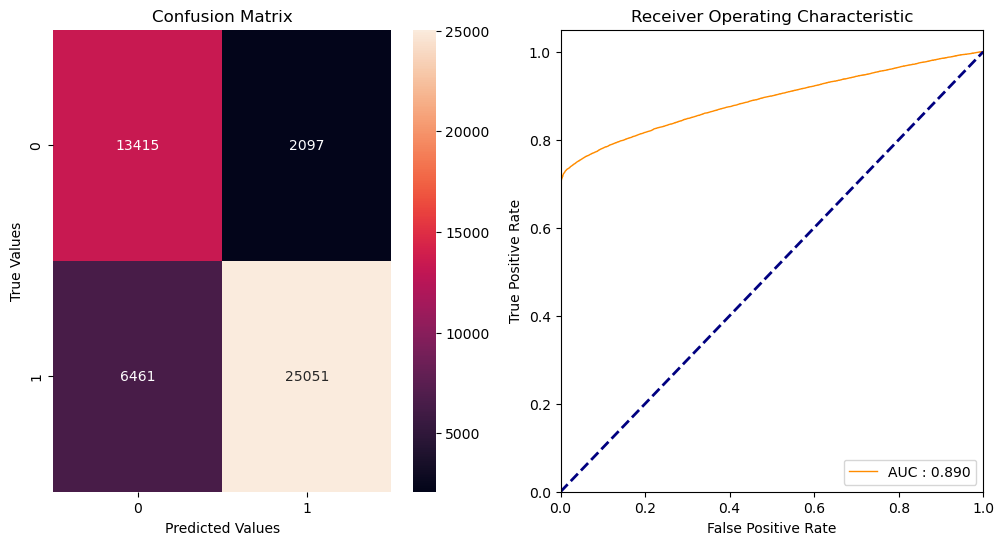

In [19]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall", "F1"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    cv_f1_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="f1", n_jobs=-1)
   

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                                    round(cv_f1_results.mean() * 100, 2)
                                    
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

In [ ]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')
plt.plot(model_results['Algorithm'], model_results['F1'], marker='o', label='F1', color='m')


plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', 'auto'], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Define Stratified K-fold CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    scoring='roc_auc', 
    cv=skf, 
    n_iter=10,  # Randomly search 20 combinations
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


In [ ]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

In [ ]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

In [ ]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [ ]:
# Define hyperparameter search space

xgb_params_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3], 
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10],  
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [0.5, 1, 1.5, 2, 5], 
    'max_delta_step': [0, 1, 3, 5], 
    'tree_method': ['hist']
}

# Define Stratified K-fold CV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize base model
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1, eval_metric="aucpr")


# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=20,  # Randomly search 20 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)




In [ ]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  gamma=best_params['gamma'],
                                  reg_alpha=best_params['reg_alpha'],
                                  reg_lambda=best_params['reg_lambda'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  max_delta_step=best_params['max_delta_step'],
                                  tree_method=best_params['tree_method'],
                                  seed=42,
                                  n_jobs=-1,
                                  eval_metric="aucpr",
                                  early_stopping_rounds=10,
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=True
                     )

In [ ]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

In [ ]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [ ]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [ ]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))